# 5-7. 프로젝트: Spectrogram classification 모델 구현

그래서 오늘은 방금 든 궁금증을 해결해 보는 것으로 프로젝트를 진행해 봅니다.

오늘 실습에서 1차원 Waveform 데이터를 입력받아 Text 라벨을 출력하는 모델을 기본 버전과 Skip-connection 버전으로 나누어 학습시켜 보았습니다. 이번에는 2차원 Spectrogram 데이터를 입력받아 위 모델과 동일한 역할을 수행하는 모델을 아래 제시된 단계와 같이 수행해 보시기 바랍니다. 이번에도 마찬가지로 기본 버전과 Skip-connection 버전으로 나누어 각각 진행해 보시기 바랍니다.  
모델 구조를 제외하고는 실습에서 제시된 것과 거의 동일하게 진행될 것입니다.

---

#### 1. 데이터 처리와 분류
- 라벨 데이터 처리하기

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import IPython.display as ipd
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
import librosa
import librosa.display
from tensorflow.keras import layers

In [2]:
data_path = os.getenv("HOME")+'/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

# speech_data["wav_vals"].shape => (50620, 8000)
# speech_data[label_vals"].shape => (50620, 1)

# 주어진 데이터의 원래 sample rate는 16000이지만, 8000으로 re-sampling해서 사용.
# 모두 1초 길이를 가지는 오디오 음성데이터여서 각각 8000개의 sample data를 가지고 있다.

In [3]:
# text로 이루어진 라벨 데이터를 학습에 사용하기 위해 index 형태로 바꿔주는 작업을 한다.
target_list = ['yes', 'no', 'up', 'down',
               'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

# int로 이루어진 index 작업을 통해 label data를 더 쉽게 사용할 수 있다.
temp = []
for v in speech_data["label_vals"][:30000, :]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

In [4]:
# spectrogram shape을 맞추기위해서 size 변형
def wav2spec(wav, fft_size=258):
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

In [5]:
# 1차원의 Wavaform 데이터를 2차원의 Spectrogram 데이터로 변환
spec_data = []
for wav in speech_data["wav_vals"][:30000, :]:
    spec_data.append(wav2spec(wav))

spec_data = np.array(spec_data)

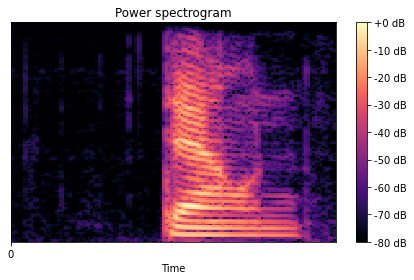

In [11]:
librosa.display.specshow(librosa.amplitude_to_db(
    spec_data, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

- `sklearn`의 `train_test_split`함수를 이용하여 train, test 분리

In [7]:
# sr = 8000
# train_wav, test_wav, train_label, test_label = train_test_split(
#     speech_data["wav_vals"], label_data, test_size=0.1, shuffle=True)
train_wav, test_wav, train_label, test_label = train_test_split(
    spec_data, label_data, test_size=0.1, shuffle=True)

In [8]:
# add channel for CNN
# train_wav = train_wav.reshape([-1, sr, 1])
# test_wav = test_wav.reshape([-1, sr, 1])

# train_wav.shape => (45558, 8000, 1)
# train_label.shape => (45558,)
# test_wav.shape => (5062, 8000, 1)
# test_label.shape => (5062,)

#### 2. 학습을 위한 하이퍼파라미터 설정

In [9]:
batch_size = 32
max_epochs = 10

# 모델 체크포인트 저장을 위한 체크포인트의 경로를 설정해준다.
# 후에 모델 체크포인트 Callback 함수를 설정하거나, 모델을 불러올 때 사용한다.
checkpoint_dir = os.getenv('HOME')+'/speech_recognition/models/wav'

#### 3. 데이터셋 구성
- `tf.data.Dataset`을 이용
- from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용
- map과 batch를 이용한 데이터 전처리
- 주의 : waveform을 spectrogram으로 변환하기 위해 추가로 사용하는 메모리 때문에 이후 메모리 부족 현상을 겪게 될수도 있습니다.
`tf.data.Dataset`이 생성된 이후, 아래 예시와 같이 wav 데이터나 spectrogram 데이터를 담아둔 메모리 버퍼를 비워 주면 도움이 됩니다.
```
del speech_data
del spec_data
```

In [10]:
# map 함수에 넘겨줄 데이터 전처리 함수
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

In [11]:
# tf.data.Dataset 함수를 구성
# batch는 dataset에서 제공하는 튜플 형태의 데이터를 얼마나 가져올지 결정하는 함수

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)

In [14]:
del speech_data
del spec_data

#### 4. 2차원 Spectrogram 데이터를 처리하는 모델 구성
- 2차원 Spectrogram 데이터의 시간축 방향으로 Conv1D layer를 적용, 혹은 Conv2D layer를 적용 가능
- batchnorm, dropout, dense layer 등을 이용
- 12개의 단어 class를 구분하는 loss를 사용하고 Adam optimizer를 사용
- 모델 가중치를 저장하는 checkpoint callback 함수 추가
- 다양한 모델의 실험을 진행해 보시기 바랍니다.

In [64]:
input_tensor = layers.Input(shape=(130, 126))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 130, 126)]        0         
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 130, 32)           36320     
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 130, 32)           9248      
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 65, 32)            0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 65, 64)            18496     
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 65, 64)            36928     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 32, 64)            0   

In [65]:
# label : 12개의 단어 class
# multi-class classification이 필요
# 이를 수행하기 위한 loss로 categorical cross-entropy loss를 사용

optimizer = tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(
    from_logits=True), optimizer=optimizer, metrics=['accuracy'])

In [66]:
# callback 함수를 이용해 학습 중간중간에 원하는 동작을 하도록 설정할 수 있다.
# 모델을 재사용하기 위해 모델 가중치를 저장하는 callback 함수를 추가.

# model checkpoint callback은 모델의 학습을 진행하며,
# fit 함수 내 다양한 인자를 지정해 모니터하며 동작하게 설정할 수 있다.

# 현재 모델은 validation loss를 모니터하며,
# loss가 낮아지면 모델 파라미터를 저장하도록 구성.

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [67]:
# 모델 학습 코드
# batch_size = 32
max_epochs = 4
# 메모리 사용량에 주의

history_wav = model_wav.fit(train_dataset,
                            epochs=max_epochs,
                            steps_per_epoch=len(train_wav)//batch_size,
                            validation_data=test_dataset,
                            validation_steps=len(test_wav)//batch_size,
                            callbacks=[cp_callback])

Epoch 1/4
838/843 [============================>.] - ETA: 0s - loss: 1.4865 - accuracy: 0.4755
Epoch 00001: val_loss improved from inf to 0.93605, saving model to /home/aiffel-dj61/speech_recognition/models/wav
843/843 [==============================] - 6s 7ms/step - loss: 1.4836 - accuracy: 0.4766 - val_loss: 0.9360 - val_accuracy: 0.6784
Epoch 2/4
836/843 [============================>.] - ETA: 0s - loss: 0.7458 - accuracy: 0.7439
Epoch 00002: val_loss improved from 0.93605 to 0.57957, saving model to /home/aiffel-dj61/speech_recognition/models/wav
843/843 [==============================] - 6s 7ms/step - loss: 0.7447 - accuracy: 0.7443 - val_loss: 0.5796 - val_accuracy: 0.7940
Epoch 3/4
839/843 [============================>.] - ETA: 0s - loss: 0.4849 - accuracy: 0.8352
Epoch 00003: val_loss improved from 0.57957 to 0.46831, saving model to /home/aiffel-dj61/speech_recognition/models/wav
843/843 [==============================] - 6s 7ms/step - loss: 0.4849 - accuracy: 0.8351 - val_lo

#### 5. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력
- loss, accuracy를 그래프로 표현

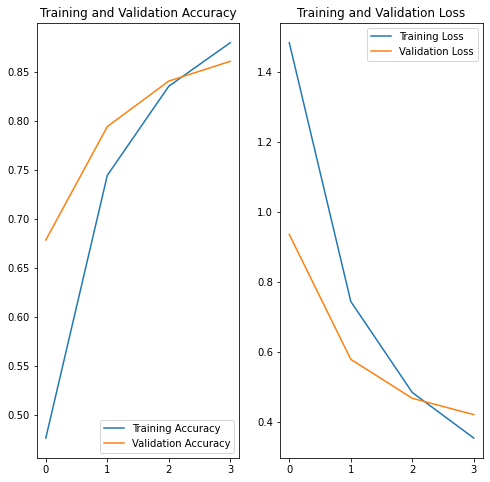

In [68]:
# train loss와 val loss의 차이가 커지는 경우 오버피팅이 일어나는 것

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss = history_wav.history['loss']
val_loss = history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### 6. Test dataset을 이용해서 모델의 성능을 평가
- 저장한 weight 불러오기
- 모델의 예측값과 정답값이 얼마나 일치하는지 확인

In [70]:
# test dataset을 이용해 모델의 성능을 평가

# 저장한 weight 불러오기
model_wav.load_weights(checkpoint_dir)

In [71]:
results = model_wav.evaluate(test_dataset)

94/94 [==============================] - 0s 3ms/step - loss: 0.4214 - accuracy: 0.8610


In [72]:
print("loss value: {:.3f}".format(results[0]))           # loss
print("accuracy value: {:.4f}%".format(results[1]*100))  # accuracy

loss value: 0.421
accuracy value: 86.1000%


#### 7. Skip-Connection medel 구현

In [86]:
input_tensor = layers.Input(shape=(130, 126))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

model_wav_skip.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 130, 126)]   0                                            
__________________________________________________________________________________________________
conv1d_70 (Conv1D)              (None, 130, 32)      36320       input_8[0][0]                    
__________________________________________________________________________________________________
conv1d_71 (Conv1D)              (None, 130, 32)      9248        conv1d_70[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_28 (MaxPooling1D) (None, 65, 32)       0           conv1d_71[0][0]                  
____________________________________________________________________________________________

In [87]:
optimizer = tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                       optimizer=optimizer,
                       metrics=['accuracy'])

In [88]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [89]:
max_epochs = 5

In [90]:
history_wav_skip = model_wav_skip.fit(train_dataset,
                                      epochs=max_epochs,
                                      steps_per_epoch=len(
                                          train_wav)//batch_size,
                                      validation_data=test_dataset,
                                      validation_steps=len(
                                          test_wav)//batch_size,
                                      callbacks=[cp_callback])

Epoch 1/5
840/843 [============================>.] - ETA: 0s - loss: 1.6350 - accuracy: 0.4299
Epoch 00001: val_loss improved from inf to 1.08978, saving model to /home/aiffel-dj61/speech_recognition/models/wav_skip
843/843 [==============================] - 6s 7ms/step - loss: 1.6333 - accuracy: 0.4305 - val_loss: 1.0898 - val_accuracy: 0.6116
Epoch 2/5
843/843 [==============================] - ETA: 0s - loss: 0.8867 - accuracy: 0.6924
Epoch 00002: val_loss improved from 1.08978 to 0.64946, saving model to /home/aiffel-dj61/speech_recognition/models/wav_skip
843/843 [==============================] - 6s 7ms/step - loss: 0.8867 - accuracy: 0.6924 - val_loss: 0.6495 - val_accuracy: 0.7839
Epoch 3/5
840/843 [============================>.] - ETA: 0s - loss: 0.5454 - accuracy: 0.8164
Epoch 00003: val_loss improved from 0.64946 to 0.47912, saving model to /home/aiffel-dj61/speech_recognition/models/wav_skip
843/843 [==============================] - 6s 7ms/step - loss: 0.5453 - accuracy: 

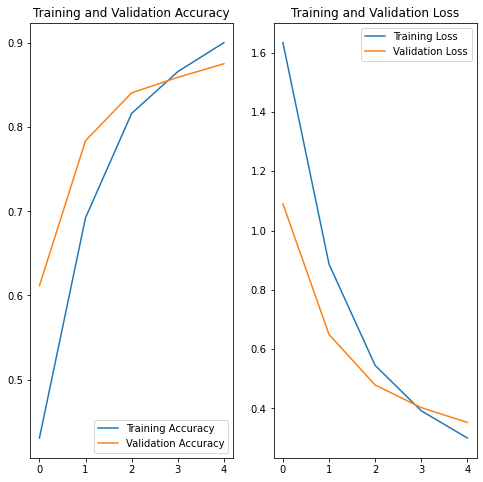

In [91]:
acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss = history_wav_skip.history['loss']
val_loss = history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [92]:
# Evaluation

model_wav_skip.load_weights(checkpoint_dir)
results = model_wav_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

94/94 [==============================] - 0s 3ms/step - loss: 0.3526 - accuracy: 0.8753
loss value: 0.353
accuracy value: 87.5333%


# 5-8. 프로젝트 제출

**루브릭**

아래의 기준을 바탕으로 프로젝트를 평가합니다.

|평가문항|상세기준|
|:---|:---|
|1. 음성데이터를 2차원 Spectrogram 으로 변환하여 데이터셋을 구성하였다.|스펙트로그램 시각화 및 train/test 데이터셋 구성이 정상진행되었다.|
|2. 1,2차원 데이터를 처리하는 음성인식 모델이 정상 작동한다.|스펙트로그램을 입력받은 모델이 학습과정에서 안정적으로 수렴하며, evaluation/test 단계를 무리없이 진행가능하다.|
|3. 테스트셋 수행결과 음성인식 모델의 Accuracy가 일정 수준에 도달하였다.|evaluation 결과 75% 이상의 정확도를 달성하는 모델이 하나 이상 존재한다.|

# 후기

|후기|
|:---|
|푸리에 변환이나 오일러 공식 같은 내용은 지금은 이해하려면 시간이 너무 많이 필요할 것 같아 포기.. 언젠가 필요할 때 공부하는 것으로..|
|음성데이터를 사용해 머신러닝을 구현해보는 경험은 좋았다. 하지만 아직 모델 레이어를 구성하는 이론에 대한 이해가 부족하고 음성데이터를 스펙토그램으로 변환하면 무엇이 좋은지 잘 모르겠다. 실제로 정확도도 1% 정도 차이가 났다. 이해가 부족하니 아직은 복붙 따라하기 수준..|
|max_epochs는 오버피팅이 일어나기 시작하는 시점인 4로 잡았다. 10으로 잡았을 때가 정확도는 조금 더 높은 것 같지만 오버피팅이 심해 4로 잡았다.|
|여기서는 validation data를 test data로 사용했지만 둘을 구분지어서도 해보고 싶다. 하지만 시간이 부족해 패스.|
|역시 이론이 중요한 것 같다. 이론공부를 해야겠다.|